In [1]:
import warnings
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_json(
    "hf://datasets/Salesforce/xlam-function-calling-60k/xlam_function_calling_60k.json"
)
df.head()

id                                                                                                                                 query                                                                                                                                 answers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [3]:
df["query"] = df["query"].astype(str)
df["answers"] = df["answers"].apply(lambda x: json.loads(x))
df["tools"] = df["tools"].apply(lambda x: json.loads(x))

### Example JSON Data

```json
{
  "query": "Find the sum of all the multiples of 3 and 5 between 1 and 1000. Also find the product of the first five prime numbers.",
  "tools": [
    {
      "name": "math_toolkit.sum_of_multiples",
      "description": "Find the sum of all multiples of specified numbers within a specified range.",
      "parameters": {
        "lower_limit": {
          "type": "int",
          "description": "The start of the range (inclusive).",
          "required": true
        },
        "upper_limit": {
          "type": "int",
          "description": "The end of the range (inclusive).",
          "required": true
        },
        "multiples": {
          "type": "list",
          "description": "The numbers to find multiples of.",
          "required": true
        }
      }
    },
    {
      "name": "math_toolkit.product_of_primes",
      "description": "Find the product of the first n prime numbers.",
      "parameters": {
        "count": {
          "type": "int",
          "description": "The number of prime numbers to multiply together.",
          "required": true
        }
      }
    }
  ],
  "answers": [
    {
      "name": "math_toolkit.sum_of_multiples",
      "arguments": {
        "lower_limit": 1,
        "upper_limit": 1000,
        "multiples": [3, 5]
      }
    },
    {
      "name": "math_toolkit.product_of_primes",
      "arguments": {
        "count": 5
      }
    }
  ]
}


In [4]:
def calculate_metrics(row):
    tools = row["tools"]
    answers = row["answers"]
    cnt_tools = len(tools)
    unique_used_tools = len(set(answer["name"] for answer in answers))
    cnt_used_tools = len(answers)
    cnt_params = sum(len(tool["parameters"]) for tool in tools)
    cnt_used_params = sum(len(answer["arguments"]) for answer in answers)

    return pd.Series(
        {
            "total_tools": cnt_tools,
            "total_arguments": cnt_params,
            "used_tools": cnt_used_tools,
            "unique_used_tools": unique_used_tools,
            "used_arguments": cnt_used_params,
        }
    )

In [5]:
row = df.iloc[2]
print(row)
calculate_metrics(row)

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

total_tools          2
total_arguments      8
used_tools           1
unique_used_tools    1
used_arguments       3
dtype: int64

In [6]:
metrics = df.apply(calculate_metrics, axis=1)
metrics.head()

,total_tools,total_arguments,used_tools,unique_used_tools,used_arguments
0,1,1,2,1,2
1,2,2,1,1,1
2,2,8,1,1,3
3,2,27,1,1,3
4,1,1,1,1,1


In [7]:
metrics_df = pd.concat([df, metrics], axis=1)
metrics_df.head()

id                                                                                                                                 query                                                                                                                                 answers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [8]:
metrics.describe()

,total_tools,total_arguments,used_tools,unique_used_tools,used_arguments
count,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000
mean,2.81450,6.041367,1.666850,1.389767,2.802983
std,1.60361,4.795537,0.852256,0.591513,1.895572
min,1.00000,1.000000,1.000000,1.000000,0.000000
25%,1.00000,3.000000,1.000000,1.000000,2.000000
50%,3.00000,5.000000,2.000000,1.000000,2.000000
75%,4.00000,8.000000,2.000000,2.000000,4.000000
max,8.00000,66.000000,52.000000,6.000000,104.000000


In [9]:
def plot_top_usage(used, total):
    used_args_quant = metrics_df[used].quantile(0.999)
    highest_usage = metrics_df[metrics_df[used] > used_args_quant]
    highest_usage = highest_usage.sort_values(by=used)
    ids = set(highest_usage["id"])
    print(f"id count: {len(ids)}")
    print(f"ids: {ids}")
    melted_df = highest_usage.melt(
        id_vars=["id"],
        value_vars=[used, total],
        var_name="metric",
        value_name="count",
    )

    plt.figure(figsize=(15, 10))
    sns.barplot(
        data=melted_df,
        x="id",
        y="count",
        hue="metric",
        order=highest_usage["id"].tolist(),
    )
    plt.title(f"TOP {used}/{total}")
    plt.xlabel("id")
    plt.ylabel("count")
    plt.tight_layout()
    plt.xticks(rotation=90)

    plt.show()
    return ids

id count: 51
ids: {36224, 44674, 12549, 56455, 10120, 59017, 55817, 33804, 21774, 58514, 39955, 26259, 53525, 6420, 45591, 59801, 43802, 33949, 57761, 55291, 59052, 56244, 45628, 43584, 41024, 39874, 47043, 53313, 13381, 48070, 53185, 58947, 40513, 48970, 55883, 53202, 46163, 59732, 50260, 47447, 50394, 57308, 37341, 50399, 56039, 38888, 38632, 38125, 46703, 47355, 38269}


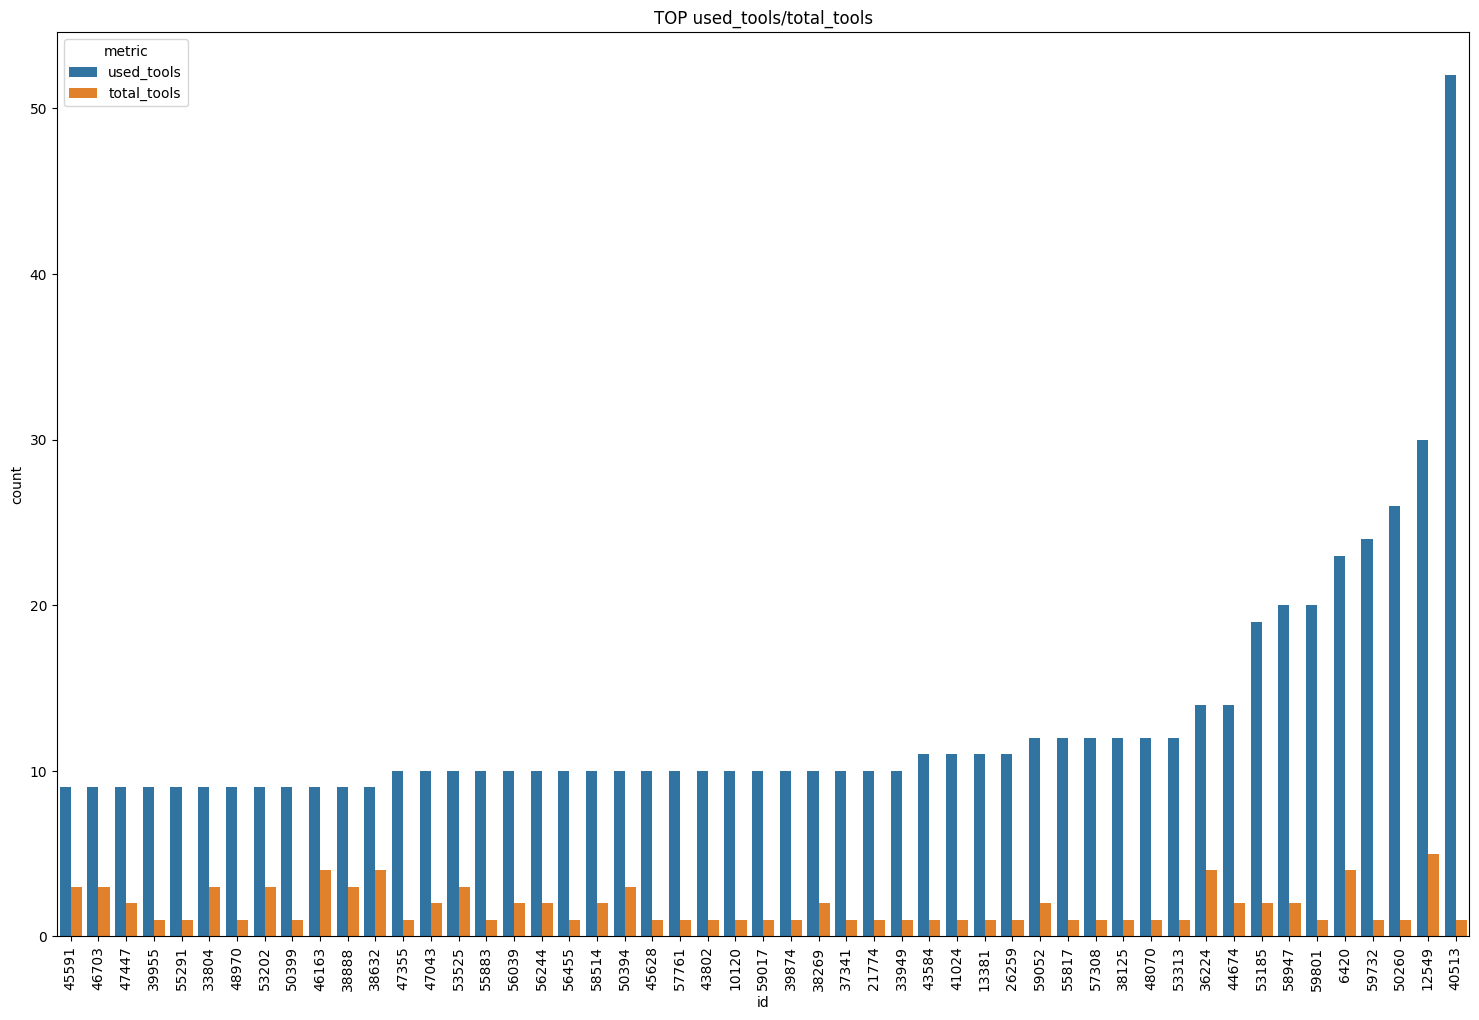

id count: 21
ids: {47119, 43159, 52763, 6431, 428, 40876, 36526, 37040, 46776, 48062, 51904, 39364, 39885, 33614, 28877, 3798, 39001, 38624, 46181, 28392, 50940}


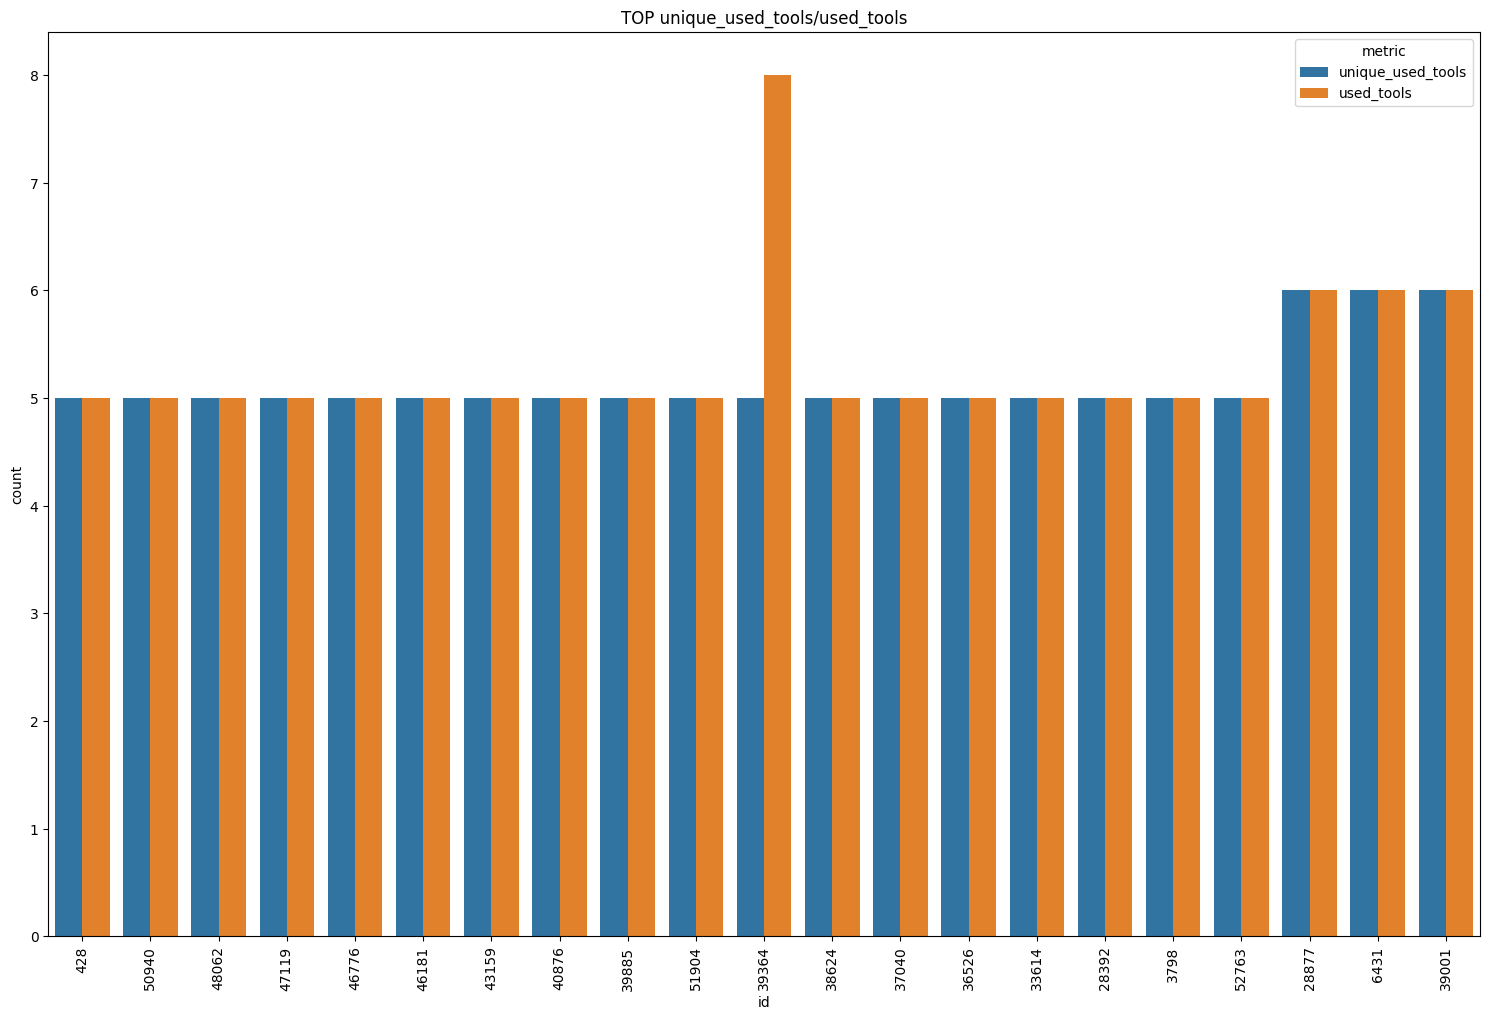

id count: 21
ids: {47119, 43159, 52763, 6431, 428, 40876, 36526, 37040, 46776, 48062, 51904, 39364, 39885, 33614, 28877, 3798, 39001, 38624, 46181, 28392, 50940}


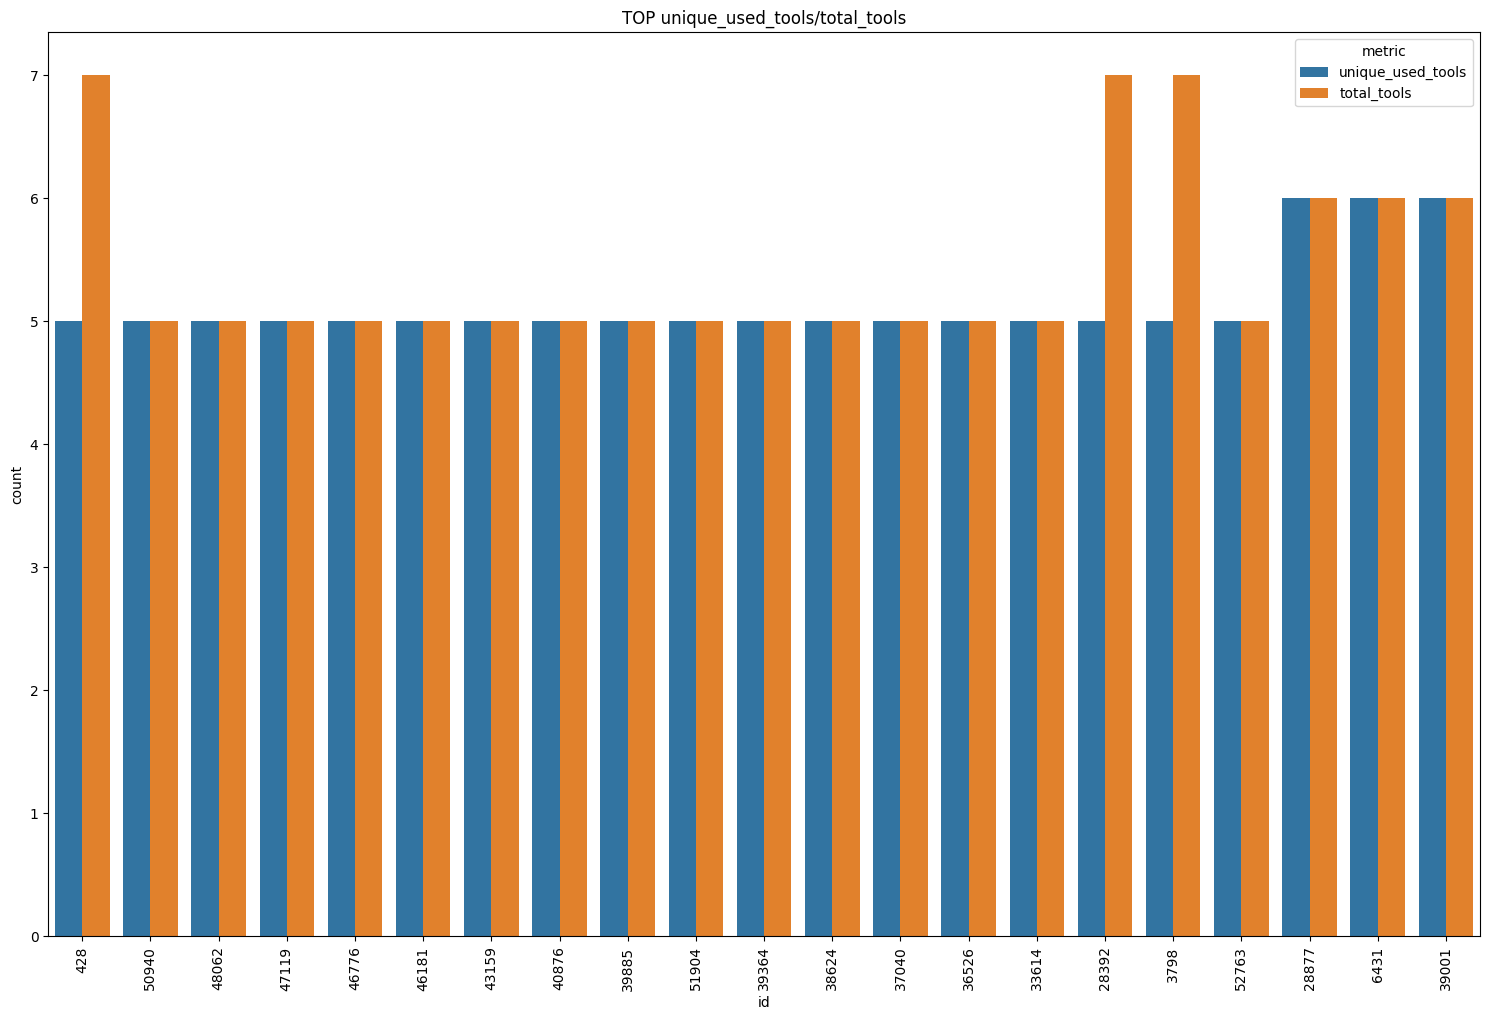

id count: 56
ids: {36224, 44674, 57732, 12549, 55817, 58514, 6420, 54806, 45591, 59801, 43802, 25499, 19869, 33949, 36129, 48547, 58020, 46373, 2600, 59052, 6959, 35254, 54329, 38975, 27840, 53185, 40513, 58947, 6212, 454, 25799, 48070, 38985, 11727, 46163, 40147, 50260, 59732, 1016, 57308, 48610, 32613, 50406, 6374, 38632, 13164, 39277, 43502, 13039, 38125, 54642, 48629, 26487, 52088, 55291, 46591}


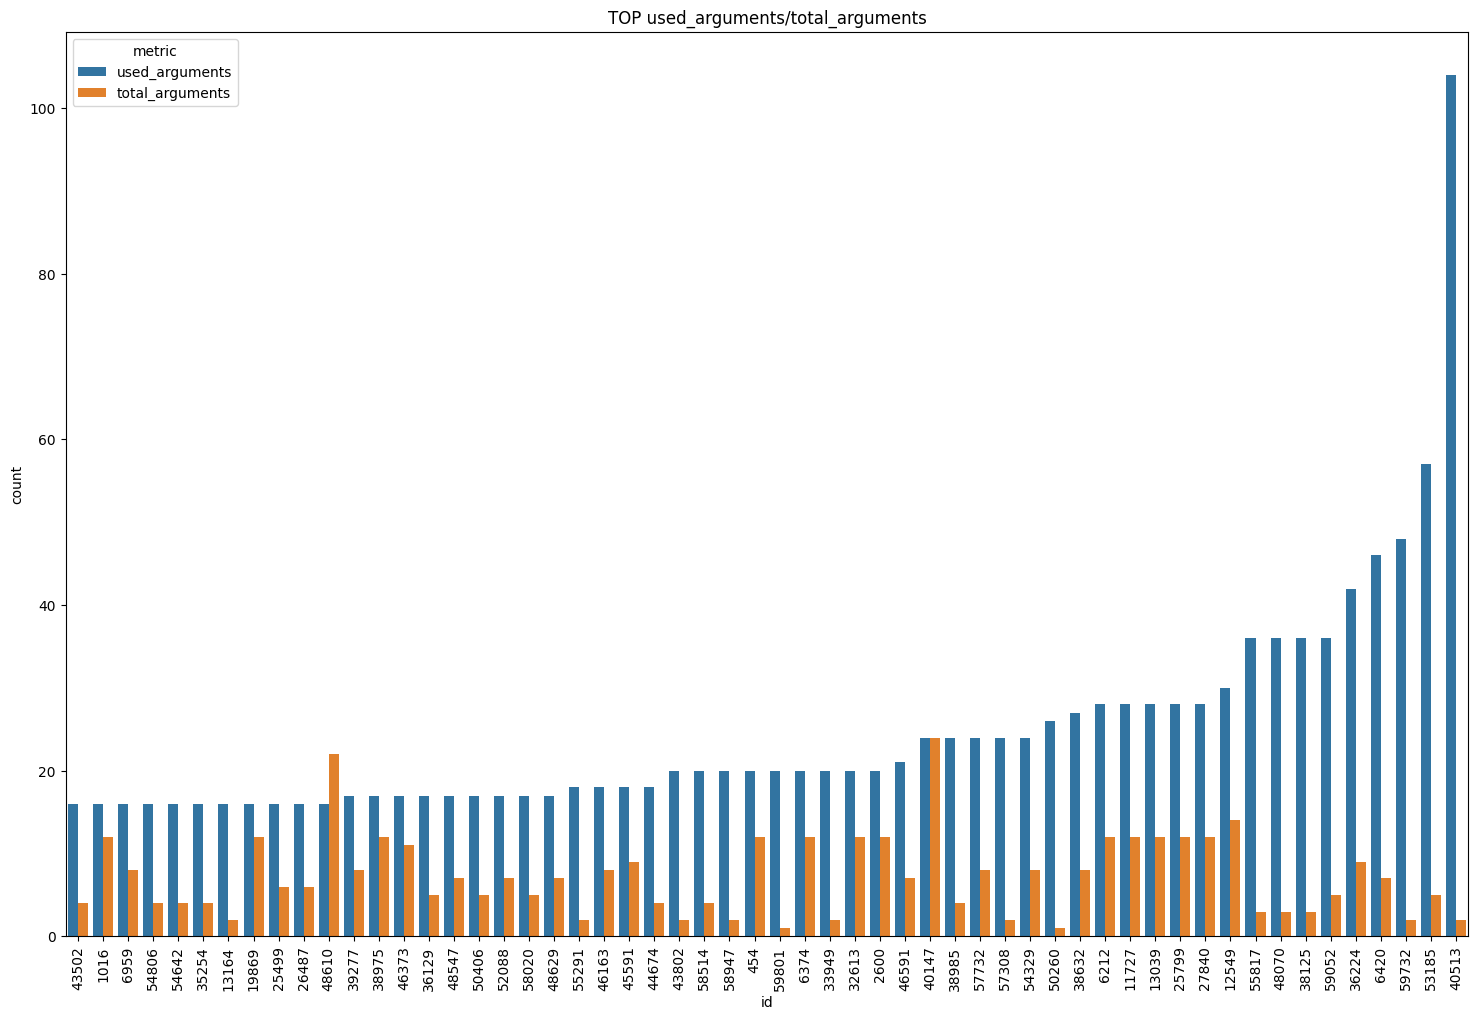

In [10]:
tools_ids = plot_top_usage("used_tools", "total_tools")
unique_used_tools_ids = plot_top_usage("unique_used_tools", "used_tools")
unique_used_tools_ids = plot_top_usage("unique_used_tools", "total_tools")
args_ids = plot_top_usage("used_arguments", "total_arguments")

In [12]:
# metrics_df[
#     metrics_df["id"].isin(
#         list(tools_ids.intersection(args_ids).union(unique_used_tools_ids))
#     )
# ]